In [1]:
from mpl_toolkits import mplot3d

from time import time

import trimesh

import tensorflow as tf

%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import numpy as np
from scipy.io import loadmat

import os
from tqdm import tqdm_notebook as tqdm

from utils import coef2object, InvalidArgumentError, \
                default_render_params, create_render_params

from rasterizer import Rasterizer

MFM_DIR = "../PublicMM1/"
MFM_NAME = "01_MorphableModel.mat"

In [2]:
# Load the MFM
if 'model' not in globals() or model is None:
    model = loadmat(MFM_DIR + MFM_NAME)
    model_size = {
        "n_shape_dim": model["shapePC"].shape[1],
        "n_tex_dim": model["texPC"].shape[1],
        "n_seg": model["segbin"].shape[1]
    }
    print("Loaded model!")
    
else:
    print("Model already loaded!")

Loaded model!


In [3]:
def display_face(shape, texture, triangulation, render_params):
    """
    Based on display_face.m provided in the University of Basel
    MFM package.
    """
   
    shape_size = np.prod(shape.shape)
    texture_size = np.prod(texture.shape)
    
    shape = shape.reshape((shape_size // 3, 3))
    texture = texture.reshape((texture_size // 3, 3))
    
    texture = tf.clip_by_value(texture, 0., 255.).numpy()
    
    mesh = trimesh.Trimesh(vertices=shape,
                           faces=triangulation,
                           vertex_colors=texture)

    return mesh

# Projection

In [13]:
alpha = tf.Variable(tf.random.normal((model_size["n_shape_dim"], 1)), name="alphas")
beta = tf.Variable(tf.random.normal((model_size["n_tex_dim"], 1)), name="betas")

shape = coef2object(alpha, 
                    model["shapeMU"], 
                    model["shapePC"], 
                    model["shapeEV"])

texture = coef2object(beta, 
                      model["texMU"], 
                      model["texPC"], 
                      model["texEV"])

render_params = create_render_params(phi=0.5)

# The triangle indices are from Matlab, which means that they start at 1
# so we correct it
triangulation = model["tl"] - 1

# Quick fix to make the winding direction of the faces right
triangulation = triangulation[:, ::-1]

In [18]:
face = display_face(shape=shape, 
                     texture=texture, 
                     triangulation=triangulation, 
                     render_params=render_params)

face.show(smooth=False)

In [15]:
r = Rasterizer()
#vertex_normals = r.calculate_vertex_normals(shape, triangulation)

with tf.GradientTape() as tape:
    start_time = time()
    image, z_buffer, tri_areas = r.rasterize(shape, texture, triangulation, num_evals=120000)
    render_time = time() - start_time

    print(f"Render time was {render_time}")

Tracing!
Iteration 5000 out of 106466
Iteration 10000 out of 106466
Iteration 15000 out of 106466
Iteration 20000 out of 106466
Iteration 25000 out of 106466
Iteration 30000 out of 106466
Iteration 35000 out of 106466
Iteration 40000 out of 106466
Iteration 45000 out of 106466
Iteration 50000 out of 106466
Iteration 55000 out of 106466
Iteration 60000 out of 106466
Iteration 65000 out of 106466
Iteration 70000 out of 106466
Iteration 75000 out of 106466
Iteration 80000 out of 106466
Iteration 85000 out of 106466
Iteration 90000 out of 106466
Iteration 95000 out of 106466
Iteration 100000 out of 106466
Iteration 105000 out of 106466
Render time was 50.55403804779053


In [16]:
image_ = tf.clip_by_value(image, 0., 1.)
image_ = tf.transpose(image_, [1, 0, 2])

<IPython.core.display.Javascript object>


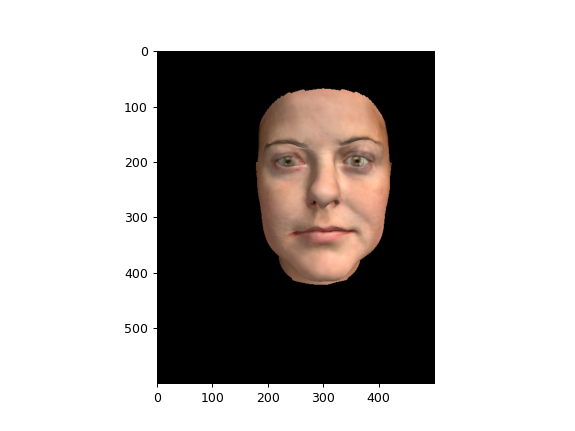

In [17]:
plt.figure()
plt.imshow(image_)

<IPython.core.display.Javascript object>


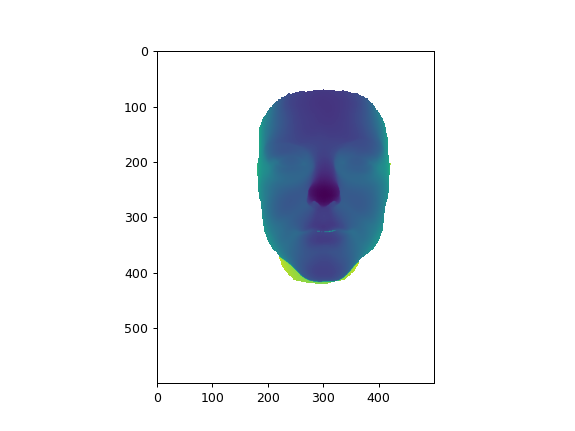

In [19]:
plt.figure()
plt.imshow(tf.transpose(z_buffer))

In [16]:
shape = shape.reshape((-1, 3))
texture = texture.reshape((-1, 3)) / 255.

In [98]:
r = tf.range(10)

def test_box_fn(x):
    
    counter = 0
    i = int(0)
    while i < x:
        counter += 1
        
        i = i + 1
    
    return tf.reduce_sum(r)

tf.map_fn(test_box_fn, r)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([45, 45, 45, 45, 45, 45, 45, 45, 45, 45], dtype=int32)>

In [17]:
# ========================================
# Define Constants
# ========================================

# Image dimensions
image_height = 1600
image_width = 1200

# Clipping planes
near = 0.1
far = 1000

aspect_ratio = image_width / image_height

# 45 degrees FOV is a standard setting in video games
fov = 45

camera_position = np.array([0, 80000, -250000])

# Camera orientation
azimuth = 180
elevation = -3

# Ambient light intensity: standard 18% intensity
amb_light_int = 0.6 * np.array([1, 1, 1])

# Directional light
# intensity: white light
dir_light_int = 0.6 * np.array([1, 1, 1])

# direction
dir_light_dir = np.array([1, 1, 1])

# normalize the light direction
dir_light_dir = dir_light_dir / np.linalg.norm(dir_light_dir)

# Phong exponent
eta = 20

# Surface shininess
surface_shininess = 0.1

# ========================================
# Calculate translation matrices
# ========================================

r = Rasterizer()

P_ = r.perspective_proj_mat().numpy()
world_to_camera_ = r.world_to_camera_mat().numpy()

# Camera position (translation)
T = np.eye(4)
T[3, :3] = camera_position

# Camera rotation
R_az = get_R_az(-azimuth)
R_el = get_R_el(-elevation)

R = R_az.dot(R_el)

# World-to-Camera matrix
world_to_camera = R.dot(T)

# Perspective projector
P = get_perspective_proj_mat(near, far, fov, aspect_ratio)

In [20]:
vertex_normals = r.calculate_vertex_normals(shape, triangulation).numpy()

normals = vertex_normals

image = tf.Variable(tf.zeros((image_height, image_width, 3)))
z_buffer = tf.Variable(np.inf * tf.ones((image_height, image_width)))

viewport_x, viewport_y, clip_z = r.rasterize(shape, 
            texture, 
            vertex_normals,
            triangulation, 
            render_parameters=None, 
            perspective=True)


# Get triangle coordinates
triangles_x = viewport_x.numpy()[triangulation]
triangles_y = viewport_y.numpy()[triangulation]
triangles_z = clip_z.numpy()[triangulation]

texture_red = texture[:, 0][triangulation]
texture_green = texture[:, 1][triangulation]
texture_blue = texture[:, 2][triangulation]

vertex_normals = normals[triangulation]
tri_vertices = tf.convert_to_tensor(shape[triangulation], dtype=tf.float32)

tris_2d = tf.concat((tf.reshape(viewport_x, [-1, 1]), tf.reshape(viewport_y, [-1, 1])), axis=1)

# Calculate triangle areas

# Concatenate x and y coordinates together
vertices_2d = tf.concat((tf.reshape(viewport_x, [-1, 1]), tf.reshape(viewport_y, [-1, 1])), axis=1)

# Convert triangulation into a tensor
triangulation_ = tf.reshape(tf.convert_to_tensor(triangulation, dtype=tf.int32), [-1, 1])

# Select the corners of the triangles T x 3 x 2
tris_2d = tf.reshape(tf.gather_nd(vertices_2d, triangulation_), [-1, 3, 2])

# Get the corresponding z values for each triangle vertex for depth checks and interpolation
# Adding a 3rd dimension allows us to do broadcasted division later
tris_2d_z = tf.reshape(tf.gather_nd(clip_z, triangulation_), [-1, 3, 1])

# Convert the texture
texture_ = tf.convert_to_tensor(texture, dtype=tf.float32)
tris_texture = tf.reshape(tf.gather_nd(texture_, triangulation_), [-1, 3, 3])

# Append 0 z-coords such that we can take the cross product between sides
tris_2d_ = tf.concat((tris_2d, tf.zeros(tris_2d.shape.as_list()[:-1] + [1])), axis=2)

# The triangle areas are half the norm of the cross product between the appropriate edge vectors
# Since the edges are on the x-y plane, the cross product will only lie on the z axis 
# (x, y coords will be 0)
#
# We actually keep the factor of 2, because it will cancel later with the edge function's factor
tri_areas = tf.linalg.cross(tris_2d_[:, 0, :] - tris_2d_[:, 2, :], 
                            tris_2d_[:, 1, :] - tris_2d_[:, 0, :])[:, 2]

# Get triangle bounding boxes:
# 1. find the bounding box of each triangle
# 2. round the coordinates up/down to whole numbers
# 3. cast them to integers
tri_x_max = tf.cast(tf.math.ceil(tf.reduce_max(tris_2d[:, :, 0], axis=1)), dtype=tf.int32)
tri_x_min = tf.cast(tf.math.floor(tf.reduce_min(tris_2d[:, :, 0], axis=1)), dtype=tf.int32)

tri_y_max = tf.cast(tf.math.ceil(tf.reduce_max(tris_2d[:, :, 1], axis=1)), dtype=tf.int32)
tri_y_min = tf.cast(tf.math.floor(tf.reduce_min(tris_2d[:, :, 1], axis=1)), dtype=tf.int32)

tri_x_max

# Calculate this for interpolation later
tri_2d_inv_z = 1. / tris_2d_z

texture_depth_ratio = tris_texture * tri_2d_inv_z

dir_light_dir = tf.reshape(tf.convert_to_tensor(dir_light_dir, dtype=tf.float32), [1, -1])
dir_light_int = tf.reshape(tf.convert_to_tensor(dir_light_int, dtype=tf.float32), [1, -1])
amb_light_int = tf.reshape(tf.convert_to_tensor(amb_light_int, dtype=tf.float32), [1, -1])
camera_position = tf.reshape(tf.convert_to_tensor(camera_position, dtype=tf.float32), [1, -1])


# def rasterize_triangle(image,
#                        z_buffer,
#                        tri_index,
#                        tri_x_max, 
#                        tri_x_min, 
#                        tri_y_max, 
#                        tri_y_min, 
#                        tris_2d, 
#                        tris_inv_depth, 
#                        tri_areas, 
#                        tex_depth_ratios, 
#                        vertex_normals, 
#                        tri_vertices):
#     x_max = tri_x_max[tri_index]
#     x_min = tri_x_min[tri_index]
#     y_max = tri_y_max[tri_index]
#     y_min = tri_y_min[tri_index]
#     tri_2d = tris_2d[tri_index]
#     tri_inv_depth = tris_inv_depth[tri_index]
#     tri_area = tri_areas[tri_index]
#     tex_depth_ratio = tex_depth_ratios[tri_index]
#     norms = vertex_normals[tri_index]
#     verts = tri_vertices[tri_index]

def rasterize_triangle(x_max,
                       x_min,
                       y_max,
                       y_min,
                       tri_2d,
                       tri_inv_depth,
                       tri_area,
                       tex_depth_ratio,
                       norms,
                       verts):
    st = time()
    global image, z_buffer
    
    # The box points are the Cartesian product between the bounds
    x_coords = tf.range(x_min, x_max)
    y_coords = tf.range(y_min, y_max)
    
    tt1 = time()
    box_points = cartesian_product(x_coords, 
                                   y_coords)
    tt1 = time() - tt1
    
    box_points = tf.reshape(box_points, [-1, 2])

    # If the box point lies outside of the image, ignore them in the calculation
    min_bound_cond = tf.math.logical_and(box_points[:, 0] >= 0, box_points[:, 1] >= 0)
    max_bound_cond = tf.math.logical_and(box_points[:, 0] < image_width, box_points[:, 1] < image_height)

    in_image_indices = tf.where(tf.math.logical_and(min_bound_cond, max_bound_cond))
    
    # Perform actual filtering
    box_points = tf.gather_nd(box_points, in_image_indices)
    
    # Calculate stuff in the middle of the pixels
    box_points_centered = tf.cast(box_points, tf.float32) + 0.5
    
    t1 = time() - st

    st = time()
    
    # Append all 0 z dimension to box coordinates
    zeros_ = tf.zeros((tf.shape(box_points_centered)[0], 1))
    box_points_centered = tf.concat((box_points_centered, zeros_), axis=1)
    
    # Append all 0 z dimension to triangle vertices
    tri_2d_with_z = tf.concat((tri_2d, 
                               tf.zeros((tri_2d.shape.as_list()[0], 1))), axis=1)
    
    # Take cross product, such that we can get the barycentric coordinates of the box coordinates
    # The norm of the cross product is just the z dimension in this case
    lamb3s = tf.linalg.cross(tri_2d_with_z[1:2, :] - box_points_centered, 
                             box_points_centered - tri_2d_with_z[:1, :])[:, 2] / tri_area
    
    lamb1s = tf.linalg.cross(tri_2d_with_z[2:, :] - box_points_centered, 
                             box_points_centered - tri_2d_with_z[1:2, :])[:, 2] / tri_area
    
    lamb2s = tf.linalg.cross(tri_2d_with_z[:1, :] - box_points_centered, 
                             box_points_centered - tri_2d_with_z[2:, :])[:, 2] / tri_area
    
    is_in_triangle_cond = tf.logical_and(lamb1s >=0,
                                         tf.logical_and(lamb2s >= 0,
                                                        lamb3s >= 0))
    is_in_triangle_indices = tf.where(is_in_triangle_cond) 
    
    # Filter box points based on whether they are in the triangle
    box_points = tf.gather_nd(box_points, is_in_triangle_indices)
    lamb1s = tf.gather_nd(lamb1s, is_in_triangle_indices)
    lamb2s = tf.gather_nd(lamb2s, is_in_triangle_indices)
    lamb3s = tf.gather_nd(lamb3s, is_in_triangle_indices)
    
    lambs = tf.stack((lamb1s, lamb2s, lamb3s), axis=1)
    
    t2 = time() - st
    
    st = time()
    
    # Interpolate the z coordinates
    box_point_depths = tf.reshape(tf.matmul(lambs, tri_inv_depth), [-1])
    
    # Check if the box points are visible
    z_buffer_at_box_points = tf.gather_nd(z_buffer, box_points)
    visible_point_indices = tf.where(z_buffer_at_box_points > box_point_depths)
    
    visible_points = tf.gather_nd(box_points, visible_point_indices)
    visible_box_point_depths = tf.gather_nd(box_point_depths, visible_point_indices)
    
    # Assign the new depths to the z-buffer
    z_buffer = tf.tensor_scatter_nd_update(z_buffer, visible_points, visible_box_point_depths)
    
    # Interpolate the colour of the pixels
    image_albedo = tf.reshape(visible_box_point_depths, [-1, 1]) * tf.matmul(lambs, tex_depth_ratio)
    
    t3 = time() - st
    
    st = time()
    
    # ----------------------------------------
    # Phong Lighting
    # ----------------------------------------
    
    # Interpolate vertex normals
    point_normals = tf.matmul(lambs, norms)
    point_normals, _ = tf.linalg.normalize(point_normals, axis=1)
    
    # Interpolate vertex coordinates in world space
    points_3d = tf.matmul(lambs, verts)
    
    # Calculate reflection direction:
    # r = -l + 2(l.n)n
    reflection_dirs = -dir_light_dir + 2 * tf.matmul(point_normals, tf.transpose(dir_light_dir)) * point_normals
    
    # Calculate viewing direction
    view_dirs = camera_position - points_3d
    view_dirs, _ = tf.linalg.normalize(view_dirs)
    
    # cosine of angle of incidence clamped to positive values only
    incidence_cos = tf.nn.relu(tf.matmul(point_normals, tf.transpose(dir_light_dir)))
    
    t4 = time() - st
    
    st = time()
    
    # cosine angle between reflection direction and viewing direction clamped to positive values only
    # Note: we are collapsing the second dimension with an inner product
    view_refl_cos = tf.reshape(tf.nn.relu(tf.einsum("ij,ij->i", view_dirs, reflection_dirs)), [-1, 1])
    
    # Calculate point colour
    diffuse_colour = (amb_light_int + tf.matmul(incidence_cos, dir_light_int)) * image_albedo
    
    specular_colour = surface_shininess * tf.pow(tf.matmul(view_refl_cos, dir_light_int), eta)
    
    colour = diffuse_colour + specular_colour
    
    # Update the image
    image = tf.tensor_scatter_nd_update(image, visible_points, colour)
    
#     return [image, 
#             z_buffer,
#             tri_index + 1]

    t5 = time() - st

    return tt1, t1, t2, t3, t4, t5

exec_times = []
for args in tqdm(zip(tri_x_max, 
                tri_x_min, 
                tri_y_max, 
                tri_y_min, 
                tris_2d, 
                tri_2d_inv_z, 
                tri_areas, 
                texture_depth_ratio, 
                vertex_normals, 
                tri_vertices), total=triangulation.shape[0]):
    
    exec_times.append(rasterize_triangle(*args))
    
    rasterize_triangle(tri_x_max=tri_x_max, 
                         tri_x_min=tri_x_min, 
                         tri_y_max=tri_y_max, 
                         tri_y_min=tri_y_min, 
                         tris_2d=tris_2d, 
                         tris_inv_depth=tri_2d_inv_z, 
                         tri_areas=tri_areas, 
                         tex_depth_ratios=texture_depth_ratio, 
                         vertex_normals=vertex_normals, 
                         tri_vertices=tri_vertices)  
    
# tri_index = tf.constant(0)    
# loop_cond = lambda im, zbuf, tri_index: tri_index < triangulation.shape[0]
# loop_body = lambda im, zbuf, idx: rasterize_triangle(im, zbuf, idx,
#                                                      tri_x_max=tri_x_max, 
#                                                      tri_x_min=tri_x_min, 
#                                                      tri_y_max=tri_y_max, 
#                                                      tri_y_min=tri_y_min, 
#                                                      tris_2d=tris_2d, 
#                                                      tris_inv_depth=tri_2d_inv_z, 
#                                                      tri_areas=tri_areas, 
#                                                      tex_depth_ratios=texture_depth_ratio, 
#                                                      vertex_normals=vertex_normals, 
#                                                      tri_vertices=tri_vertices)    

# res = tf.while_loop(loop_cond, 
#                     loop_body, 
#                     loop_vars=[image, z_buffer, tri_index], 
#                     shape_invariants=[image.get_shape(), z_buffer.get_shape(), tri_index.get_shape()],)

/Users/gergelyflamich/Documents/Miscellaneous/MorphableFaceModel/mfm_venv/lib/python3.7/site-packages/ipykernel_launcher.py:261: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


TypeError: rasterize_triangle() got an unexpected keyword argument 'tri_x_max'

In [9]:
def cartesian_product_(a):

    u, v = a[0][ None, :, None ], a[1][ :, None, None ]
    
    prod = tf.concat( [ u + tf.zeros_like( v ),
                        tf.zeros_like( u ) + v ], axis = 2 )
    return prod

In [47]:
@tf.function
def test_fn(x, y):
    if x < 0.:
        return -1., y
    else:
        return 1., y + 1

In [27]:
image = tf.zeros((image_height, image_width, 3))
z_buffer = np.inf * tf.ones((image_height, image_width))

def rasterize_triangles(x_maxs,
                        x_mins,
                        y_maxs,
                        y_mins,
                        tris_2d,
                        tris_inv_depth,
                        tris_area,
                        tex_depth_ratios,
                        norms,
                        verts):
    st = time()
    global image, z_buffer
    
    # The box points are the Cartesian product between the bounds
    x_coords = tf.ragged.range(x_mins, x_maxs)
    y_coords = tf.ragged.range(y_mins, y_maxs)
    
    coords = tf.ragged.stack((x_coords, y_coords), axis=1)
    
    boxes = []
    
    for coord in coords:
        boxes.append(tf.ragged.constant(tf.reshape(cartesian_product_(coord), [1, -1, 2]).numpy()))
    
    return tf.concat(boxes, axis=0)
    
    tt1 = time()
    box_points = cartesian_product(x_coords, 
                                   y_coords)
    tt1 = time() - tt1
    
    box_points = tf.reshape(box_points, [-1, 2])

    # If the box point lies outside of the image, ignore them in the calculation
    min_bound_cond = tf.math.logical_and(box_points[:, 0] >= 0, box_points[:, 1] >= 0)
    max_bound_cond = tf.math.logical_and(box_points[:, 0] < image_width, box_points[:, 1] < image_height)

    in_image_indices = tf.where(tf.math.logical_and(min_bound_cond, max_bound_cond))
    
    # Perform actual filtering
    box_points = tf.gather_nd(box_points, in_image_indices)
    
    # Calculate stuff in the middle of the pixels
    box_points_centered = tf.cast(box_points, tf.float32) + 0.5
    
    t1 = time() - st

    st = time()
    
    # Append all 0 z dimension to box coordinates
    zeros_ = tf.zeros((tf.shape(box_points_centered)[0], 1))
    box_points_centered = tf.concat((box_points_centered, zeros_), axis=1)
    
    # Append all 0 z dimension to triangle vertices
    tri_2d_with_z = tf.concat((tri_2d, 
                               tf.zeros((tri_2d.shape.as_list()[0], 1))), axis=1)
    
    # Take cross product, such that we can get the barycentric coordinates of the box coordinates
    # The norm of the cross product is just the z dimension in this case
    lamb3s = tf.linalg.cross(tri_2d_with_z[1:2, :] - box_points_centered, 
                             box_points_centered - tri_2d_with_z[:1, :])[:, 2] / tri_area
    
    lamb1s = tf.linalg.cross(tri_2d_with_z[2:, :] - box_points_centered, 
                             box_points_centered - tri_2d_with_z[1:2, :])[:, 2] / tri_area
    
    lamb2s = tf.linalg.cross(tri_2d_with_z[:1, :] - box_points_centered, 
                             box_points_centered - tri_2d_with_z[2:, :])[:, 2] / tri_area
    
    is_in_triangle_cond = tf.logical_and(lamb1s >=0,
                                         tf.logical_and(lamb2s >= 0,
                                                        lamb3s >= 0))
    is_in_triangle_indices = tf.where(is_in_triangle_cond) 
    
    # Filter box points based on whether they are in the triangle
    box_points = tf.gather_nd(box_points, is_in_triangle_indices)
    lamb1s = tf.gather_nd(lamb1s, is_in_triangle_indices)
    lamb2s = tf.gather_nd(lamb2s, is_in_triangle_indices)
    lamb3s = tf.gather_nd(lamb3s, is_in_triangle_indices)
    
    lambs = tf.stack((lamb1s, lamb2s, lamb3s), axis=1)
    
    t2 = time() - st
    
    st = time()
    
    # Interpolate the z coordinates
    box_point_depths = tf.reshape(tf.matmul(lambs, tri_inv_depth), [-1])
    
    # Check if the box points are visible
    z_buffer_at_box_points = tf.gather_nd(z_buffer, box_points)
    visible_point_indices = tf.where(z_buffer_at_box_points > box_point_depths)
    
    visible_points = tf.gather_nd(box_points, visible_point_indices)
    visible_box_point_depths = tf.gather_nd(box_point_depths, visible_point_indices)
    
    # Assign the new depths to the z-buffer
    z_buffer = tf.tensor_scatter_nd_update(z_buffer, visible_points, visible_box_point_depths)
    
    # Interpolate the colour of the pixels
    image_albedo = tf.reshape(visible_box_point_depths, [-1, 1]) * tf.matmul(lambs, tex_depth_ratio)
    
    t3 = time() - st
    
    st = time()
    
    # ----------------------------------------
    # Phong Lighting
    # ----------------------------------------
    
    # Interpolate vertex normals
    point_normals = tf.matmul(lambs, norms)
    point_normals, _ = tf.linalg.normalize(point_normals, axis=1)
    
    # Interpolate vertex coordinates in world space
    points_3d = tf.matmul(lambs, verts)
    
    # Calculate reflection direction:
    # r = -l + 2(l.n)n
    reflection_dirs = -dir_light_dir + 2 * tf.matmul(point_normals, tf.transpose(dir_light_dir)) * point_normals
    
    # Calculate viewing direction
    view_dirs = camera_position - points_3d
    view_dirs, _ = tf.linalg.normalize(view_dirs)
    
    # cosine of angle of incidence clamped to positive values only
    incidence_cos = tf.nn.relu(tf.matmul(point_normals, tf.transpose(dir_light_dir)))
    
    t4 = time() - st
    
    st = time()
    
    # cosine angle between reflection direction and viewing direction clamped to positive values only
    # Note: we are collapsing the second dimension with an inner product
    view_refl_cos = tf.reshape(tf.nn.relu(tf.einsum("ij,ij->i", view_dirs, reflection_dirs)), [-1, 1])
    
    # Calculate point colour
    diffuse_colour = (amb_light_int + tf.matmul(incidence_cos, dir_light_int)) * image_albedo
    
    specular_colour = surface_shininess * tf.pow(tf.matmul(view_refl_cos, dir_light_int), eta)
    
    colour = diffuse_colour + specular_colour
    
    # Update the image
    image = tf.tensor_scatter_nd_update(image, visible_points, colour)
    

    t5 = time() - st

    return tt1, t1, t2, t3, t4, t5

    
n = 1000
rasterize_triangles(tri_x_max[:n], 
                    tri_x_min[:n], 
                    tri_y_max[:n], 
                    tri_y_min[:n], 
                    tris_2d[:n], 
                    tri_2d_inv_z[:n], 
                    tri_areas[:n], 
                    texture_depth_ratio[:n], 
                    vertex_normals[:n], 
                    tri_vertices[:n])

<tf.RaggedTensor [[[839, 300], [839, 301]], [[839, 300], [839, 301]], [[839, 301], [839, 302]], [[838, 301], [839, 301], [838, 302], [839, 302], [838, 303], [839, 303]], [[838, 302], [839, 302], [838, 303], [839, 303], [838, 304], [839, 304]], [[838, 302], [839, 302], [838, 303], [839, 303], [838, 304], [839, 304]], [[838, 303], [839, 303], [838, 304], [839, 304]], [[838, 304], [839, 304], [838, 305], [839, 305]], [[838, 304], [839, 304], [838, 305], [839, 305], [838, 306], [839, 306]], [[838, 304], [839, 304], [838, 305], [839, 305], [838, 306], [839, 306]], [[838, 305], [839, 305], [838, 306], [839, 306], [838, 307], [839, 307]], [[837, 306], [838, 306], [837, 307], [838, 307], [837, 308], [838, 308]], [[837, 307], [838, 307], [837, 308], [838, 308], [837, 309], [838, 309]], [[837, 307], [838, 307], [837, 308], [838, 308], [837, 309], [838, 309]], [[837, 308], [838, 308], [837, 309], [838, 309], [837, 310], [838, 310]], [[837, 309], [838, 309], [837, 310], [838, 310], [837, 311], [83

In [22]:
tf.ragged.constant(tf.convert_to_tensor(np.arange(9).reshape((3,3))))

ValueError: TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "/Users/gergelyflamich/Documents/Miscellaneous/MorphableFaceModel/mfm_venv/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 906, in __len__
    raise TypeError("Scalar tensor has no `len()`")

TypeError: Scalar tensor has no `len()`



In [45]:
bounds = tf.stack([tri_x_max, tri_x_min, tri_y_max, tri_y_min], axis=1)

tf.ragged.map_flat_values(to_box_points, bounds)

<tf.Tensor: id=3332428, shape=(106466, 4), dtype=int32, numpy=
array([[852, 850, 290, 288],
       [852, 850, 290, 288],
       [851, 850, 291, 289],
       ...,
       [181, 178, 458, 450],
       [180, 178, 454, 450],
       [179, 178, 451, 446]], dtype=int32)>

In [ ]:
bounds

In [40]:
def to_box_points(bounds):
    
    return bounds
    
    x_max = bounds[0]
    x_min = bounds[1]
    y_max = bounds[2]
    y_min = bounds[3]

    x_coords = tf.range(x_min, x_max)
    y_coords = tf.range(y_min, y_max)
    
    tt1 = time()
    box_points = cartesian_product(x_coords, 
                                   y_coords)
    tt1 = time() - tt1
    
    box_points = tf.reshape(box_points, [-1, 2])
    
    return box_points

In [23]:
x = tf.ragged.constant([[1], [2,3]])

tf.ragged.map_flat_values(tf.add, x, x)

<tf.RaggedTensor [[2], [4, 6]]>

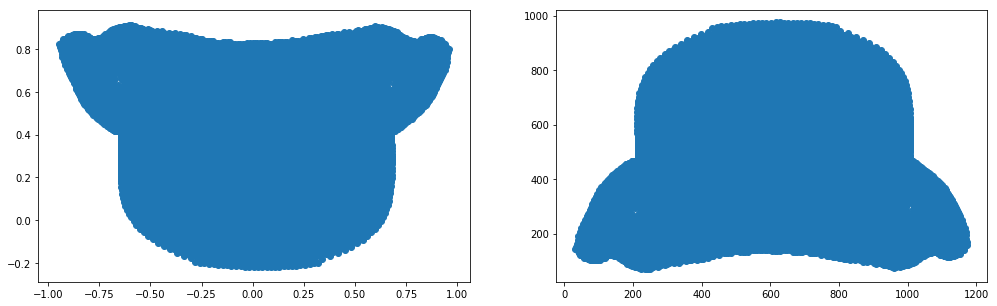

In [11]:
plt.figure(figsize=(17, 5))

plt.subplot(121)
plt.scatter(ndc_shape[:, 0], ndc_shape[:, 1])

plt.subplot(122)
plt.scatter(viewport_x, viewport_y)

plt.show()

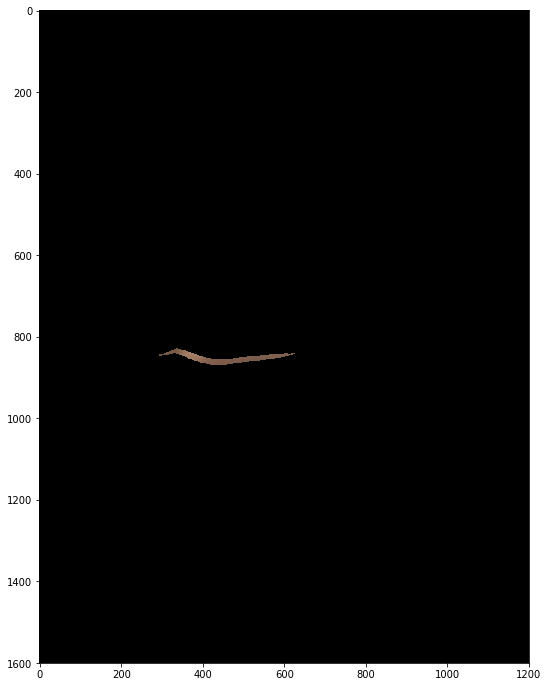

In [231]:
plt.figure(figsize=(16, 12))
plt.imshow(res[0].numpy())

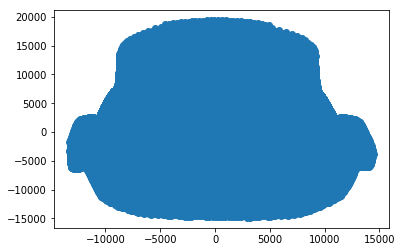

In [72]:
plt.scatter(clip_shape[:, 0], clip_shape[:, 1])

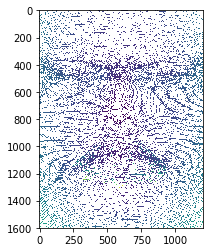

In [107]:
plt.imshow(z_buffer)

In [286]:
p_ = p_ / p_[:, 3:]

In [47]:
elems = tf.Variable(np.array([1, 2, 3, 4, 5, 6]), dtype=tf.float32)

with tf.GradientTape() as tape:
    squares = tf.map_fn(lambda x: x * x * x, elems)

tape.gradient(squares, (elems,))

(<tf.Tensor: id=2099, shape=(6,), dtype=float32, numpy=array([  3.,  12.,  27.,  48.,  75., 108.], dtype=float32)>,)

In [ ]:
# Transform from world to camera coordinates
camera_shape = shape.dot(world_to_camera)

# Project to clip space
clip_shape = camera_shape.dot(P)

# Currently don't clip here. We take the extra overhead so that we don't need to
# perform a difficult conditional check for visible triangles
# Perform clipping
# clip_cond = np.where((np.abs(clip_shape[:, 0]) <= clip_shape[:, 3]) * 
#                     (np.abs(clip_shape[:, 1]) <= clip_shape[:, 3]) * 
#                     (np.abs(clip_shape[:, 2]) <= clip_shape[:, 3]) * 
#                     (clip_shape[:, 3] > 0))[0]

# clipped_shape = clip_shape[clip_cond, :]

# Perspective divide: divide x, y, z by w
ndc_shape = clip_shape[:, :3] / clip_shape[:, 3:]

# Viewport transform
viewport_x = (ndc_shape[:, 0] + 1) * 0.5 * (image_width - 1)
# Invert along the vertical axis
viewport_y = (1 - ndc_shape[:, 1]) * 0.5 * (image_height - 1)

# Get triangle coordinates
triangles_x = viewport_x[triangulation]
triangles_y = viewport_y[triangulation]
triangles_z = ndc_shape[:, 2][triangulation]

texture_red = texture[:, 0][triangulation]
texture_green = texture[:, 1][triangulation]
texture_blue = texture[:, 2][triangulation]

vertex_normals = normals[triangulation]
tri_vertices = shape[triangulation]

   for col in range(x_min, x_max):
        if col < 0 or col >= image_width: continue
            
        for row in range(y_min, y_max):
            if row < 0 or row >= image_height: continue
            
            # Center of the pixel
            col_ = col + 0.5
            row_ = row + 0.5
            
            lamb3 = edge_fn(ax=tri_x[0], 
                            ay=tri_y[0],
                            bx=tri_x[1],
                            by=tri_y[1],
                            px=col_,
                            py=row_) / area
            
            lamb1 = edge_fn(ax=tri_x[1], 
                            ay=tri_y[1],
                            bx=tri_x[2],
                            by=tri_y[2],
                            px=col_,
                            py=row_) / area
            
            lamb2 = edge_fn(ax=tri_x[2], 
                            ay=tri_y[2],
                            bx=tri_x[0],
                            by=tri_y[0],
                            px=col_,
                            py=row_) / area
            
            is_inside = lamb1 >= 0 and lamb2 >= 0 and lamb3 >= 0
            
            if is_inside:
                    
                lamb = np.array([lamb1, lamb2, lamb3])
                
                # Interpolate the z coordinate
                pixel_z_coord = inv_tri_z.dot(lamb)
                
                
                # check the z-buffer
                if z_buffer[row, col] > pixel_z_coord:
                    
                    z_buffer[row, col] = pixel_z_coord
                    
                    image[row, col, 0] = pixel_z_coord * red_depth_ratio.dot(lamb)
                    image[row, col, 1] = pixel_z_coord * green_depth_ratio.dot(lamb)
                    image[row, col, 2] = pixel_z_coord * blue_depth_ratio.dot(lamb)
                    
                    point_normal = lamb.reshape([1, -1]).dot(norms).ravel()
                    point_3d = lamb.reshape([1, -1]).dot(verts[:, :3]).ravel()
                    
                    # Normalize the point normal
                    point_normal = point_normal / np.linalg.norm(point_normal)
                    
                    # Calculate reflection direction:
                    # r = -l + 2(l.n)n
                    reflection_dir = -dir_light_dir + 2 * (dir_light_dir.dot(point_normal)) * point_normal
                    
                    # Calculate viewing direction
                    view_dir = camera_position - point_3d
                    view_dir = view_dir / np.linalg.norm(view_dir)
                    
                    # cosine of angle of incidence clamped to positive values only
                    incidence_cos = np.maximum(0, point_normal.dot(dir_light_dir))
                    
                    # cosine angle between reflection direction and viewing direction clamped to positive values only
                    view_refl_cos = np.maximum(0, view_dir.dot(reflection_dir))
                    
                    # Calculate point colour
                    diffuse_colour = (amb_light_int + dir_light_int * incidence_cos) * image[row, col, :]
                    
                    specular_colour = surface_shininess * dir_light_int * view_refl_cos**eta
                    
                    image[row, col, :] = diffuse_colour + specular_colour

# for idx, (tri_x, tri_y, tri_z, red, green, blue, norms, verts) in \
#     tqdm(enumerate(zip(triangles_x, 
#                        triangles_y, 
#                        triangles_z, 
#                        texture_red, 
#                        texture_green, 
#                        texture_blue, 
#                        vertex_normals,
#                        tri_vertices))):
    
#     rasterize_triangle(tri_x, tri_y, tri_z, red, green, blue, norms, verts)